In [1]:
!pip install segmentation-models-pytorch --quiet
!pip install torch_optimizer --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.6 MB/s eta 0:00:00


In [5]:
import torch
torch.cuda.empty_cache()

In [44]:
import os
import numpy as np
import pandas as pd
import segmentation_models_pytorch as smp
from PIL import Image

import torch_optimizer as optim_extra
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

IMAGE_SIZE = 720
BATCH_SIZE = 8
EPOCHS = 100
MODEL_PATH = "best_model.pth"

class LeafDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, image_ids=None, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_ids = image_ids if image_ids is not None else sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.mask_dir:
            mask_name = img_name.replace(".jpg", ".png")
            mask_path = os.path.join(self.mask_dir, mask_name)
            mask_rgb = np.array(Image.open(mask_path).convert("RGB"))
            mask = ((mask_rgb[:, :, 0] > 50) & 
                    (mask_rgb[:, :, 1] < 50) & 
                    (mask_rgb[:, :, 2] < 50)).astype(np.uint8)

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask'].unsqueeze(0).float()
            else:
                image = ToTensorV2()(image=image)['image']
                mask = torch.from_numpy(mask).unsqueeze(0).float()

            return image, mask
        else:
            if self.transform:
                image = self.transform(image=image)['image']
            else:
                image = ToTensorV2()(image=image)['image']
            return image, img_name.replace(".jpg", "")

train_transform = A.Compose([
    A.CLAHE(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-10, 10), p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomScale(scale_limit=0.3, p=0.5),
    A.CoarseDropout(
        num_holes_range=(5, 10),
        hole_height_range=(IMAGE_SIZE // 20, IMAGE_SIZE // 10),
        hole_width_range=(IMAGE_SIZE // 20, IMAGE_SIZE // 10),
        fill=0,
        p=0.5
    ),
    A.GaussNoise(p=0.2),
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(),
    ToTensorV2()
])

IMAGE_DIR = "/kaggle/input/leafdisease/train/images"
MASK_DIR = "/kaggle/input/leafdisease/train/masks"
all_image_ids = sorted(os.listdir(IMAGE_DIR))

train_ids, val_ids = train_test_split(all_image_ids, test_size=0.2, random_state=42)

train_dataset = LeafDataset(IMAGE_DIR, MASK_DIR, train_ids, transform=train_transform)
val_dataset = LeafDataset(IMAGE_DIR, MASK_DIR, val_ids, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = LeafDataset("/kaggle/input/leafdisease/test/images", transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

In [18]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        targets = targets.view(-1)
        intersection = (probs * targets).sum()
        return 1 - (2. * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)

def dice_coef(pred, target, smooth=1e-6, threshold=0.3):
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, smooth=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        targets = targets.view(-1)

        TP = (probs * targets).sum()
        FP = ((1 - targets) * probs).sum()
        FN = (targets * (1 - probs)).sum()

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        return 1 - tversky

class ComboLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.focal = FocalLoss()

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        dice_loss = self.dice(logits, targets)
        focal_loss = self.focal(logits, targets)
        return 0.3 * bce_loss + 0.4 * dice_loss + 0.3 * focal_loss

class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.tversky = TverskyLoss()

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        dice_loss = self.dice(logits, targets)
        tversky_loss = self.tversky(logits, targets)

        return 0.2 * bce_loss + 0.4 * dice_loss + 0.4 * tversky_loss

In [17]:
class SMPModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = smp.DeepLabV3Plus(
            encoder_name="resnet101",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, x):
        return self.model(x)

In [27]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SMPModel().to(DEVICE)

if os.path.exists(MODEL_PATH):
    print("Loading best model...")
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
else:
    print("Starting from scratch")

base_optimizer = optim_extra.RAdam(model.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer = optim_extra.Lookahead(base_optimizer, k=5, alpha=0.5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

criterion = CombinedLoss()
best_dice = 0.0

for epoch in range(EPOCHS):
    if epoch == 20:
        for param in model.model.encoder.parameters():
            param.requires_grad = True

    model.train()
    train_loss = 0.0
    train_dice = 0.0

    for images, masks in tqdm(train_loader):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        preds = model(images)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_coef(preds, masks).item()

    model.eval()
    val_dice = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            preds = model(images)
            val_dice += dice_coef(preds, masks).item()

    val_dice /= len(val_loader)
    scheduler.step(epoch + 1)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss/len(train_loader):.4f} | Train Dice: {train_dice/len(train_loader):.4f} | Val Dice: {val_dice:.4f}")

    if val_dice > best_dice:
        print(f"\U0001F525 Saving new best model with Dice: {val_dice:.4f}")
        best_dice = val_dice
        torch.save(model.state_dict(), MODEL_PATH)

Loading best model...


100%|██████████| 44/44 [00:59<00:00,  1.34s/it]


Epoch 1/100 | Train Loss: 0.2772 | Train Dice: 0.7480 | Val Dice: 0.7766
🔥 Saving new best model with Dice: 0.7766


100%|██████████| 44/44 [00:59<00:00,  1.34s/it]


Epoch 2/100 | Train Loss: 0.2762 | Train Dice: 0.7504 | Val Dice: 0.7841
🔥 Saving new best model with Dice: 0.7841


100%|██████████| 44/44 [00:59<00:00,  1.34s/it]


Epoch 3/100 | Train Loss: 0.2812 | Train Dice: 0.7390 | Val Dice: 0.7667


100%|██████████| 44/44 [00:59<00:00,  1.36s/it]


Epoch 4/100 | Train Loss: 0.2794 | Train Dice: 0.7489 | Val Dice: 0.7786


100%|██████████| 44/44 [00:58<00:00,  1.32s/it]


Epoch 5/100 | Train Loss: 0.2700 | Train Dice: 0.7501 | Val Dice: 0.7818


100%|██████████| 44/44 [00:59<00:00,  1.35s/it]


Epoch 6/100 | Train Loss: 0.2554 | Train Dice: 0.7684 | Val Dice: 0.7741


100%|██████████| 44/44 [00:58<00:00,  1.33s/it]


Epoch 7/100 | Train Loss: 0.2711 | Train Dice: 0.7494 | Val Dice: 0.7776


100%|██████████| 44/44 [00:58<00:00,  1.33s/it]


Epoch 8/100 | Train Loss: 0.2607 | Train Dice: 0.7661 | Val Dice: 0.7781


100%|██████████| 44/44 [00:58<00:00,  1.32s/it]


Epoch 9/100 | Train Loss: 0.2558 | Train Dice: 0.7708 | Val Dice: 0.7758


100%|██████████| 44/44 [00:59<00:00,  1.35s/it]


Epoch 10/100 | Train Loss: 0.2500 | Train Dice: 0.7740 | Val Dice: 0.7696


100%|██████████| 44/44 [00:58<00:00,  1.33s/it]


Epoch 11/100 | Train Loss: 0.2673 | Train Dice: 0.7488 | Val Dice: 0.7216


100%|██████████| 44/44 [00:58<00:00,  1.34s/it]


Epoch 12/100 | Train Loss: 0.2641 | Train Dice: 0.7603 | Val Dice: 0.8020
🔥 Saving new best model with Dice: 0.8020


100%|██████████| 44/44 [00:58<00:00,  1.33s/it]


Epoch 13/100 | Train Loss: 0.2720 | Train Dice: 0.7449 | Val Dice: 0.8073
🔥 Saving new best model with Dice: 0.8073


100%|██████████| 44/44 [00:58<00:00,  1.33s/it]


Epoch 14/100 | Train Loss: 0.2577 | Train Dice: 0.7571 | Val Dice: 0.8034


100%|██████████| 44/44 [00:59<00:00,  1.36s/it]


Epoch 15/100 | Train Loss: 0.2466 | Train Dice: 0.7706 | Val Dice: 0.8059


100%|██████████| 44/44 [00:58<00:00,  1.32s/it]


Epoch 16/100 | Train Loss: 0.2400 | Train Dice: 0.7756 | Val Dice: 0.8082
🔥 Saving new best model with Dice: 0.8082


 18%|█▊        | 8/44 [00:10<00:47,  1.33s/it]


KeyboardInterrupt: 

In [10]:
sample_mask = train_dataset[0][1] 
print(torch.unique(sample_mask))

tensor([0.])


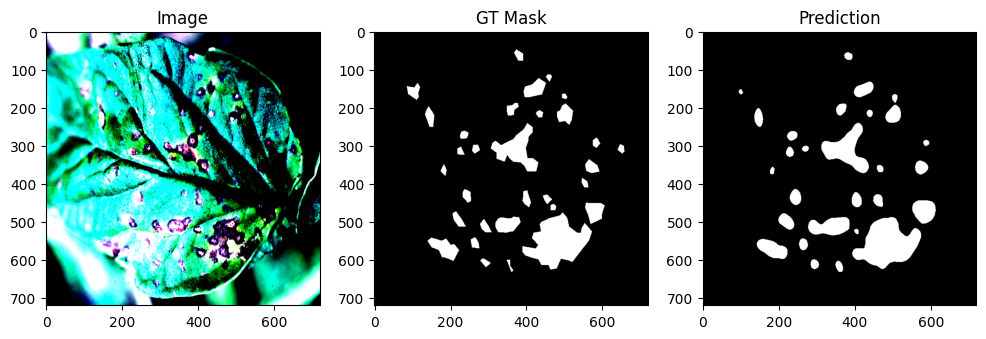

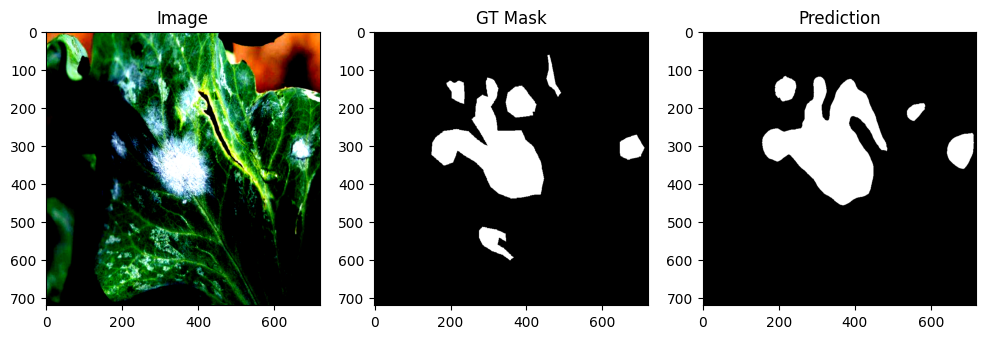

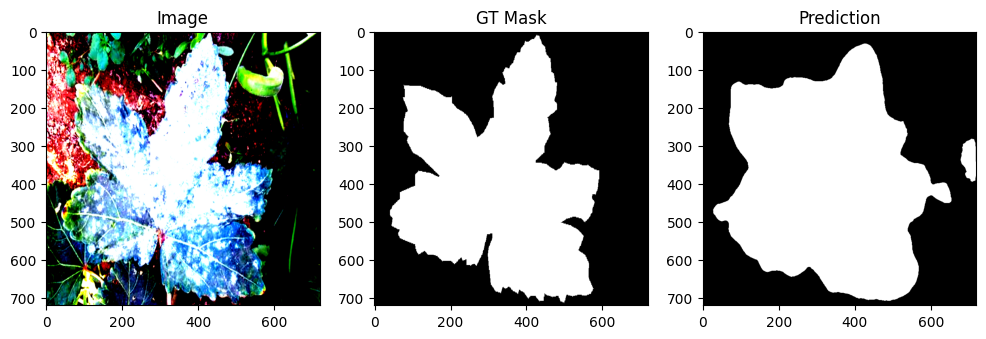

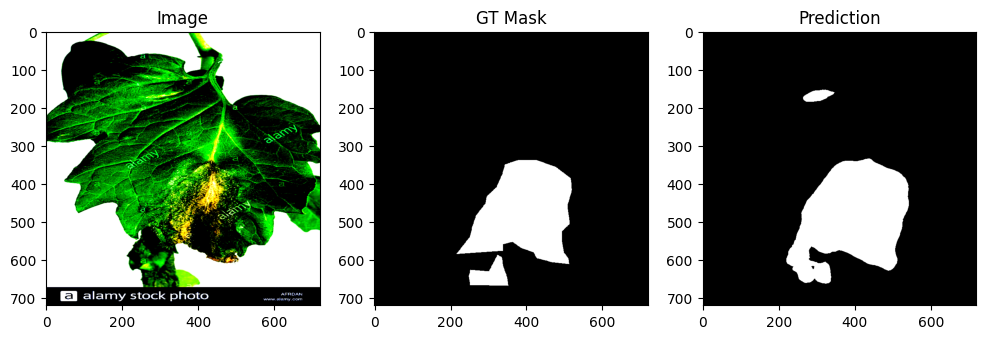

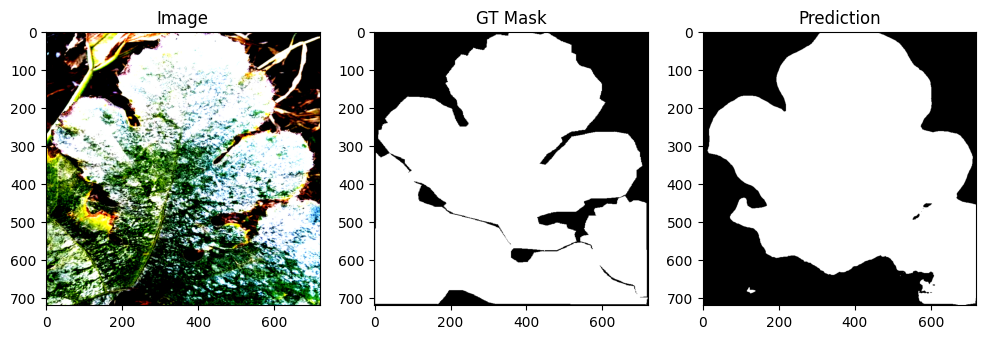

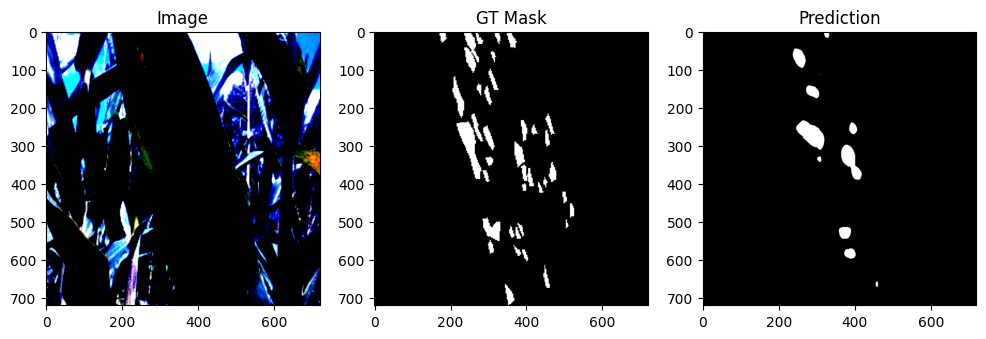

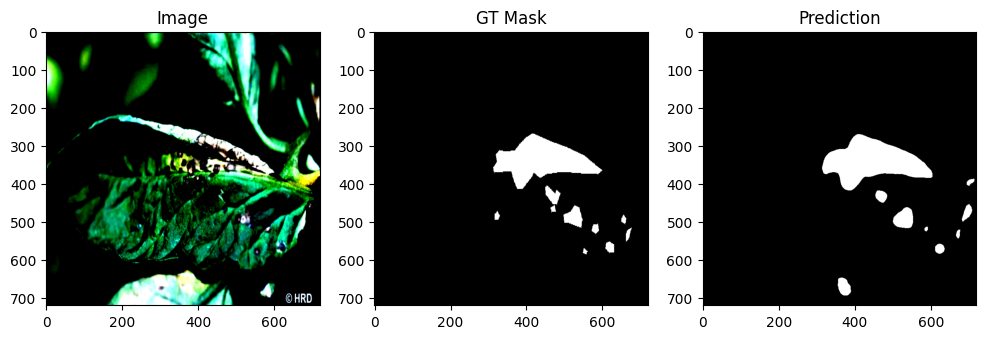

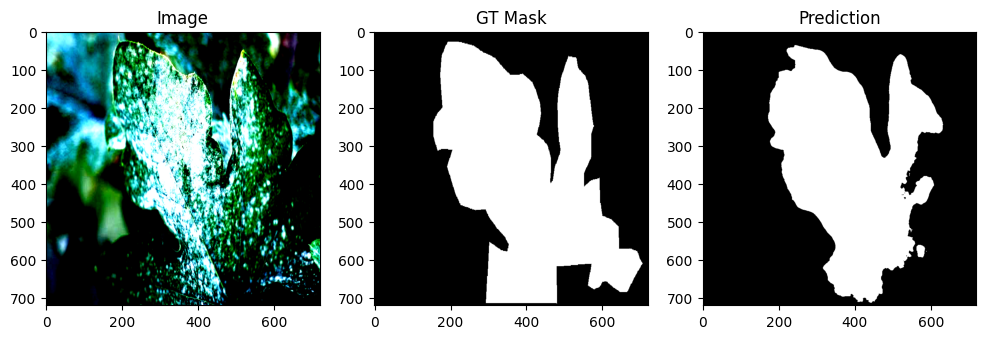

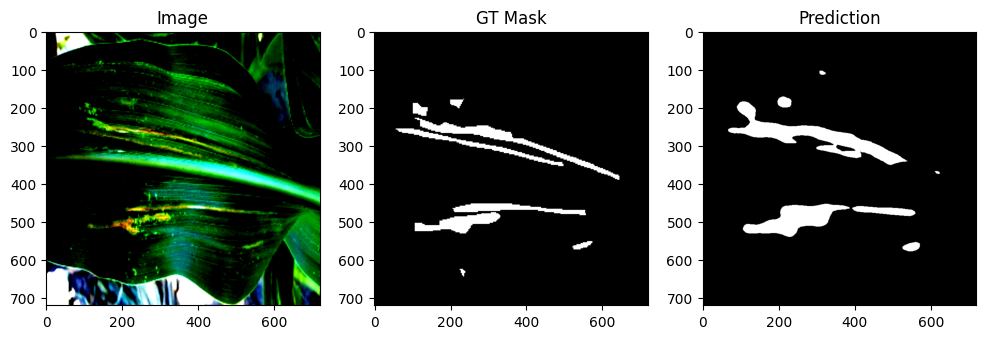

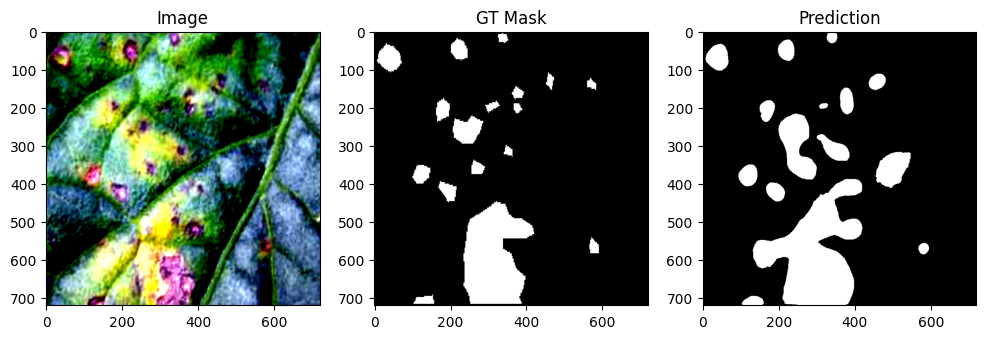

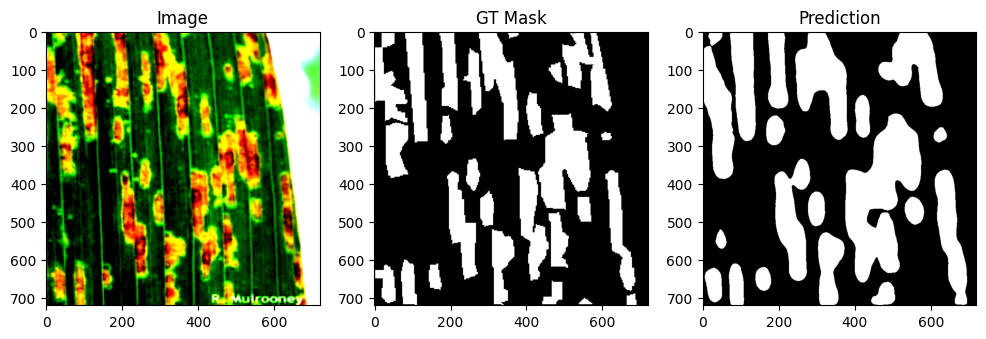

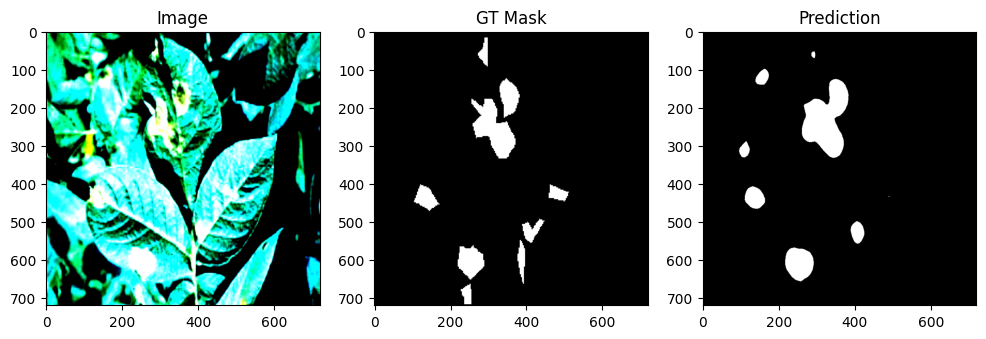

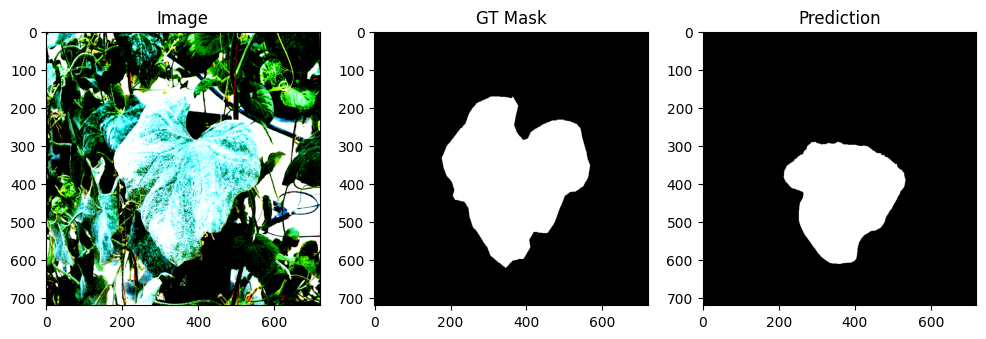

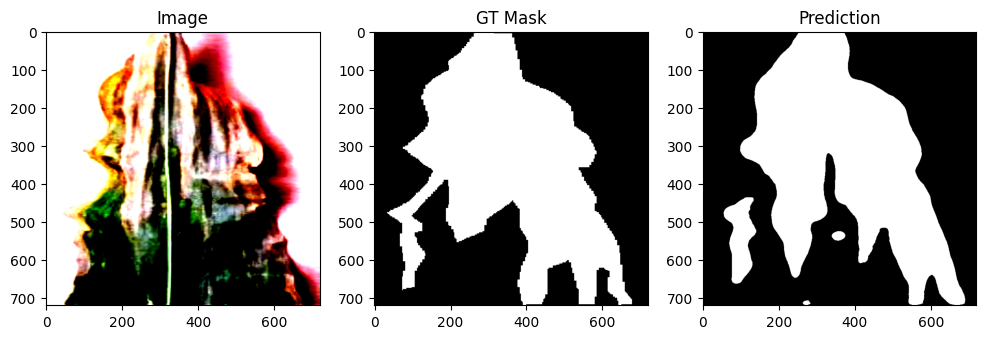

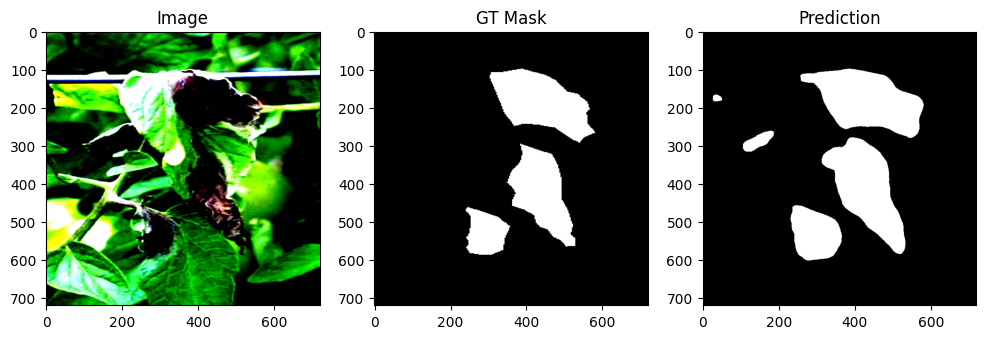

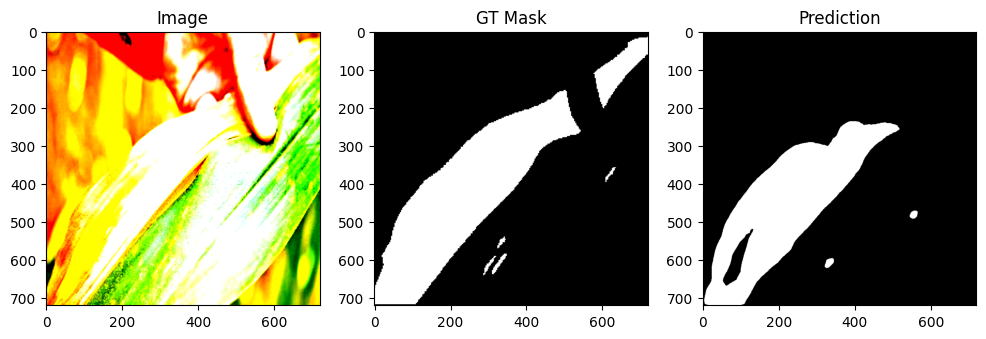

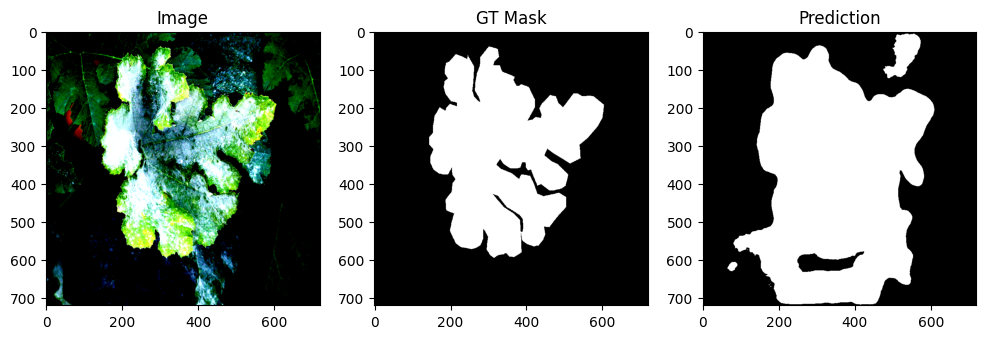

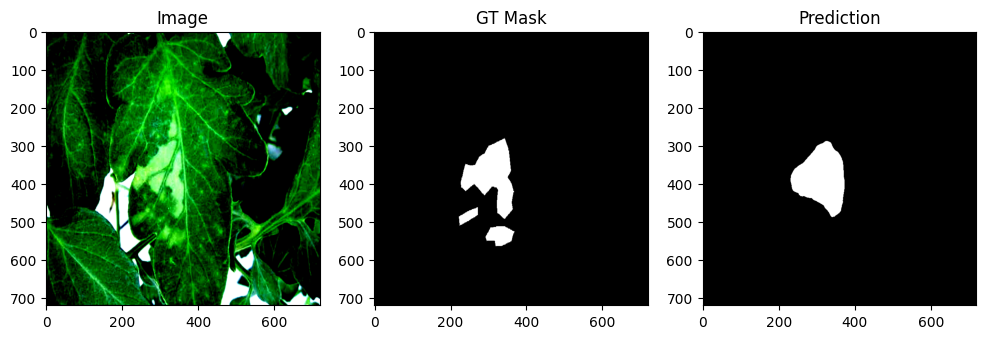

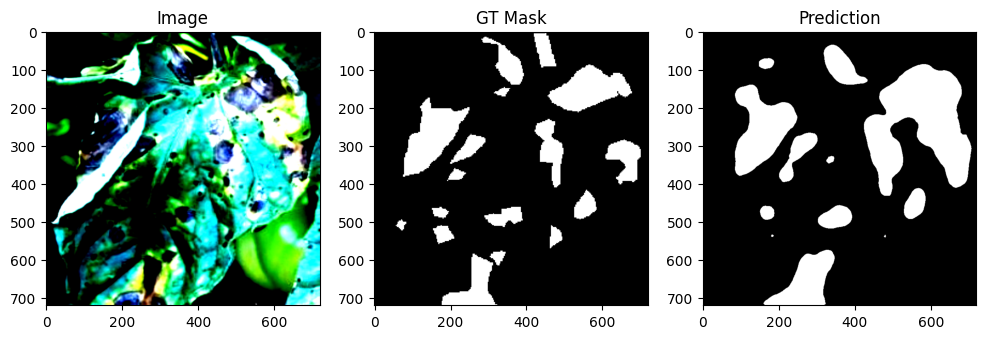

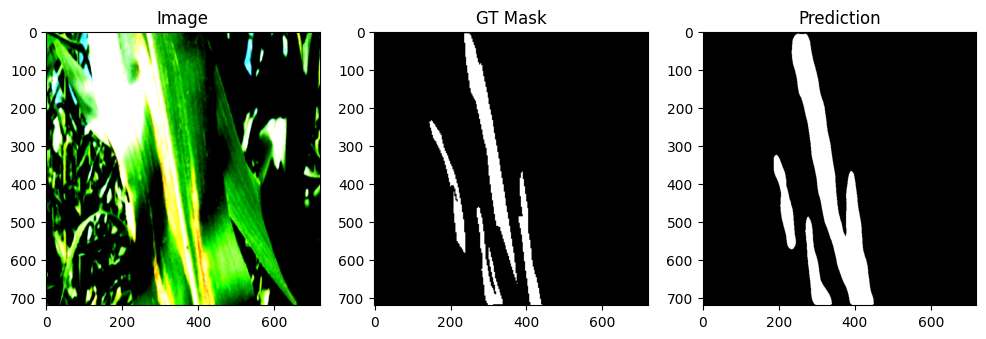

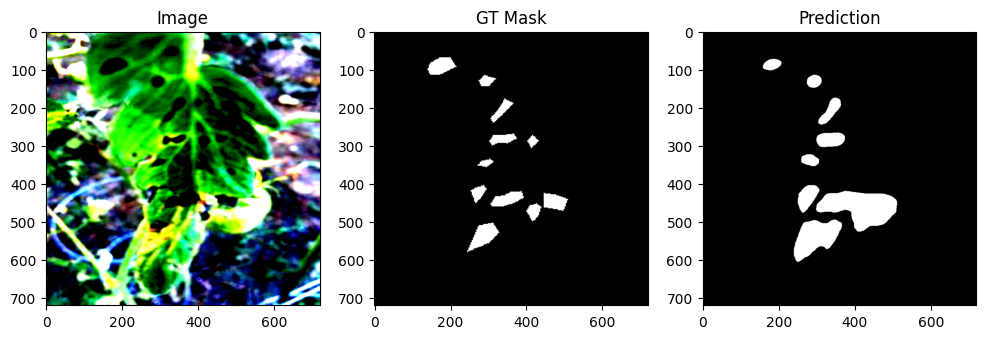

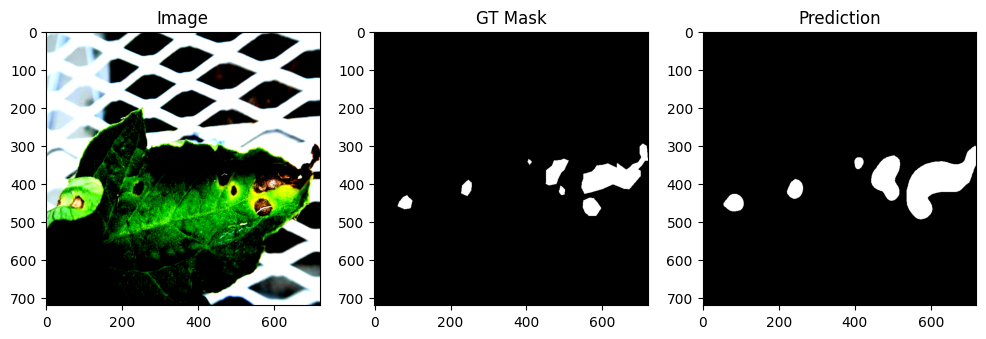

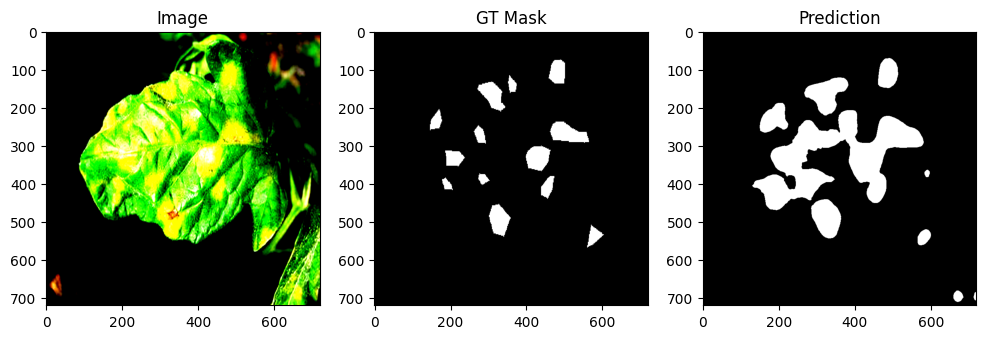

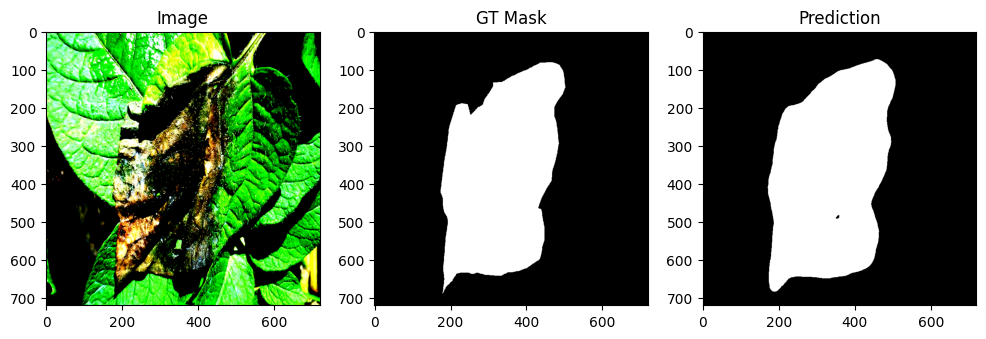

In [28]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for i, (images, masks) in enumerate(val_loader):
        images = images.to(DEVICE)
        preds = torch.sigmoid(model(images)).cpu()
        for j in range(images.size(0)):
            image = images[j].permute(1, 2, 0).cpu().numpy()
            mask = masks[j].squeeze().cpu().numpy()
            pred = preds[j].squeeze().numpy() > 0.3

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Image")
            plt.subplot(1, 3, 2)
            plt.imshow(mask, cmap="gray")
            plt.title("GT Mask")
            plt.subplot(1, 3, 3)
            plt.imshow(pred, cmap="gray")
            plt.title("Prediction")
            plt.show()

        if i >= 2: break 

In [54]:
import cv2

def create_submission(model, test_loader, device, threshold=0.3, submission_path="submission.csv"):
    model.eval()
    ids = []
    rle_masks = []

    with torch.no_grad():
        for images, image_ids in tqdm(test_loader, desc="Predicting test masks"):
            images = images.to(device)
            outputs = model(images) 
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).cpu().numpy().astype(np.uint8)

            for i, img_id in enumerate(image_ids):
                mask_720 = preds[i, 0]

                img_path = os.path.join("/kaggle/input/leafdisease/test/images", img_id + ".jpg")
                orig_img = cv2.imread(img_path)
                orig_h, orig_w = orig_img.shape[:2]

                mask_orig = cv2.resize(mask_720, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)

                rle = mask_to_rle_alternating_counts(mask_orig)
                ids.append(img_id)
                rle_masks.append(rle)

    submission_df = pd.DataFrame({"id": ids, "mask_string": rle_masks})
    submission_df.to_csv(submission_path, index=False)
    print(f"Saved submission file: {submission_path}")

create_submission(model, test_loader, DEVICE, threshold=0.3, submission_path="submission.csv")

Predicting test masks: 100%|██████████| 37/37 [00:14<00:00,  2.48it/s]

Saved submission file: submission.csv


Example 1 - Image ID: 0
RLE mask string (first 50 chars): 33407 14 33422 6 33659 28 33914 32 34168 36 34423 ...
--------------------------------------------------
Example 2 - Image ID: 101
RLE mask string (first 50 chars): 18569 10 18968 17 19367 22 19767 27 20167 30 20567...
--------------------------------------------------
Example 3 - Image ID: 105
RLE mask string (first 50 chars): 13642 5 13839 8 14038 8 14236 10 14434 12 14632 13...
--------------------------------------------------
Example 4 - Image ID: 109
RLE mask string (first 50 chars): 191288 30 192371 30 193449 58 194532 58 195612 70 ...
--------------------------------------------------
Example 5 - Image ID: 112
RLE mask string (first 50 chars): 3323 5 3422 12 3577 7 3671 22 3832 9 3924 27 4084 ...
--------------------------------------------------


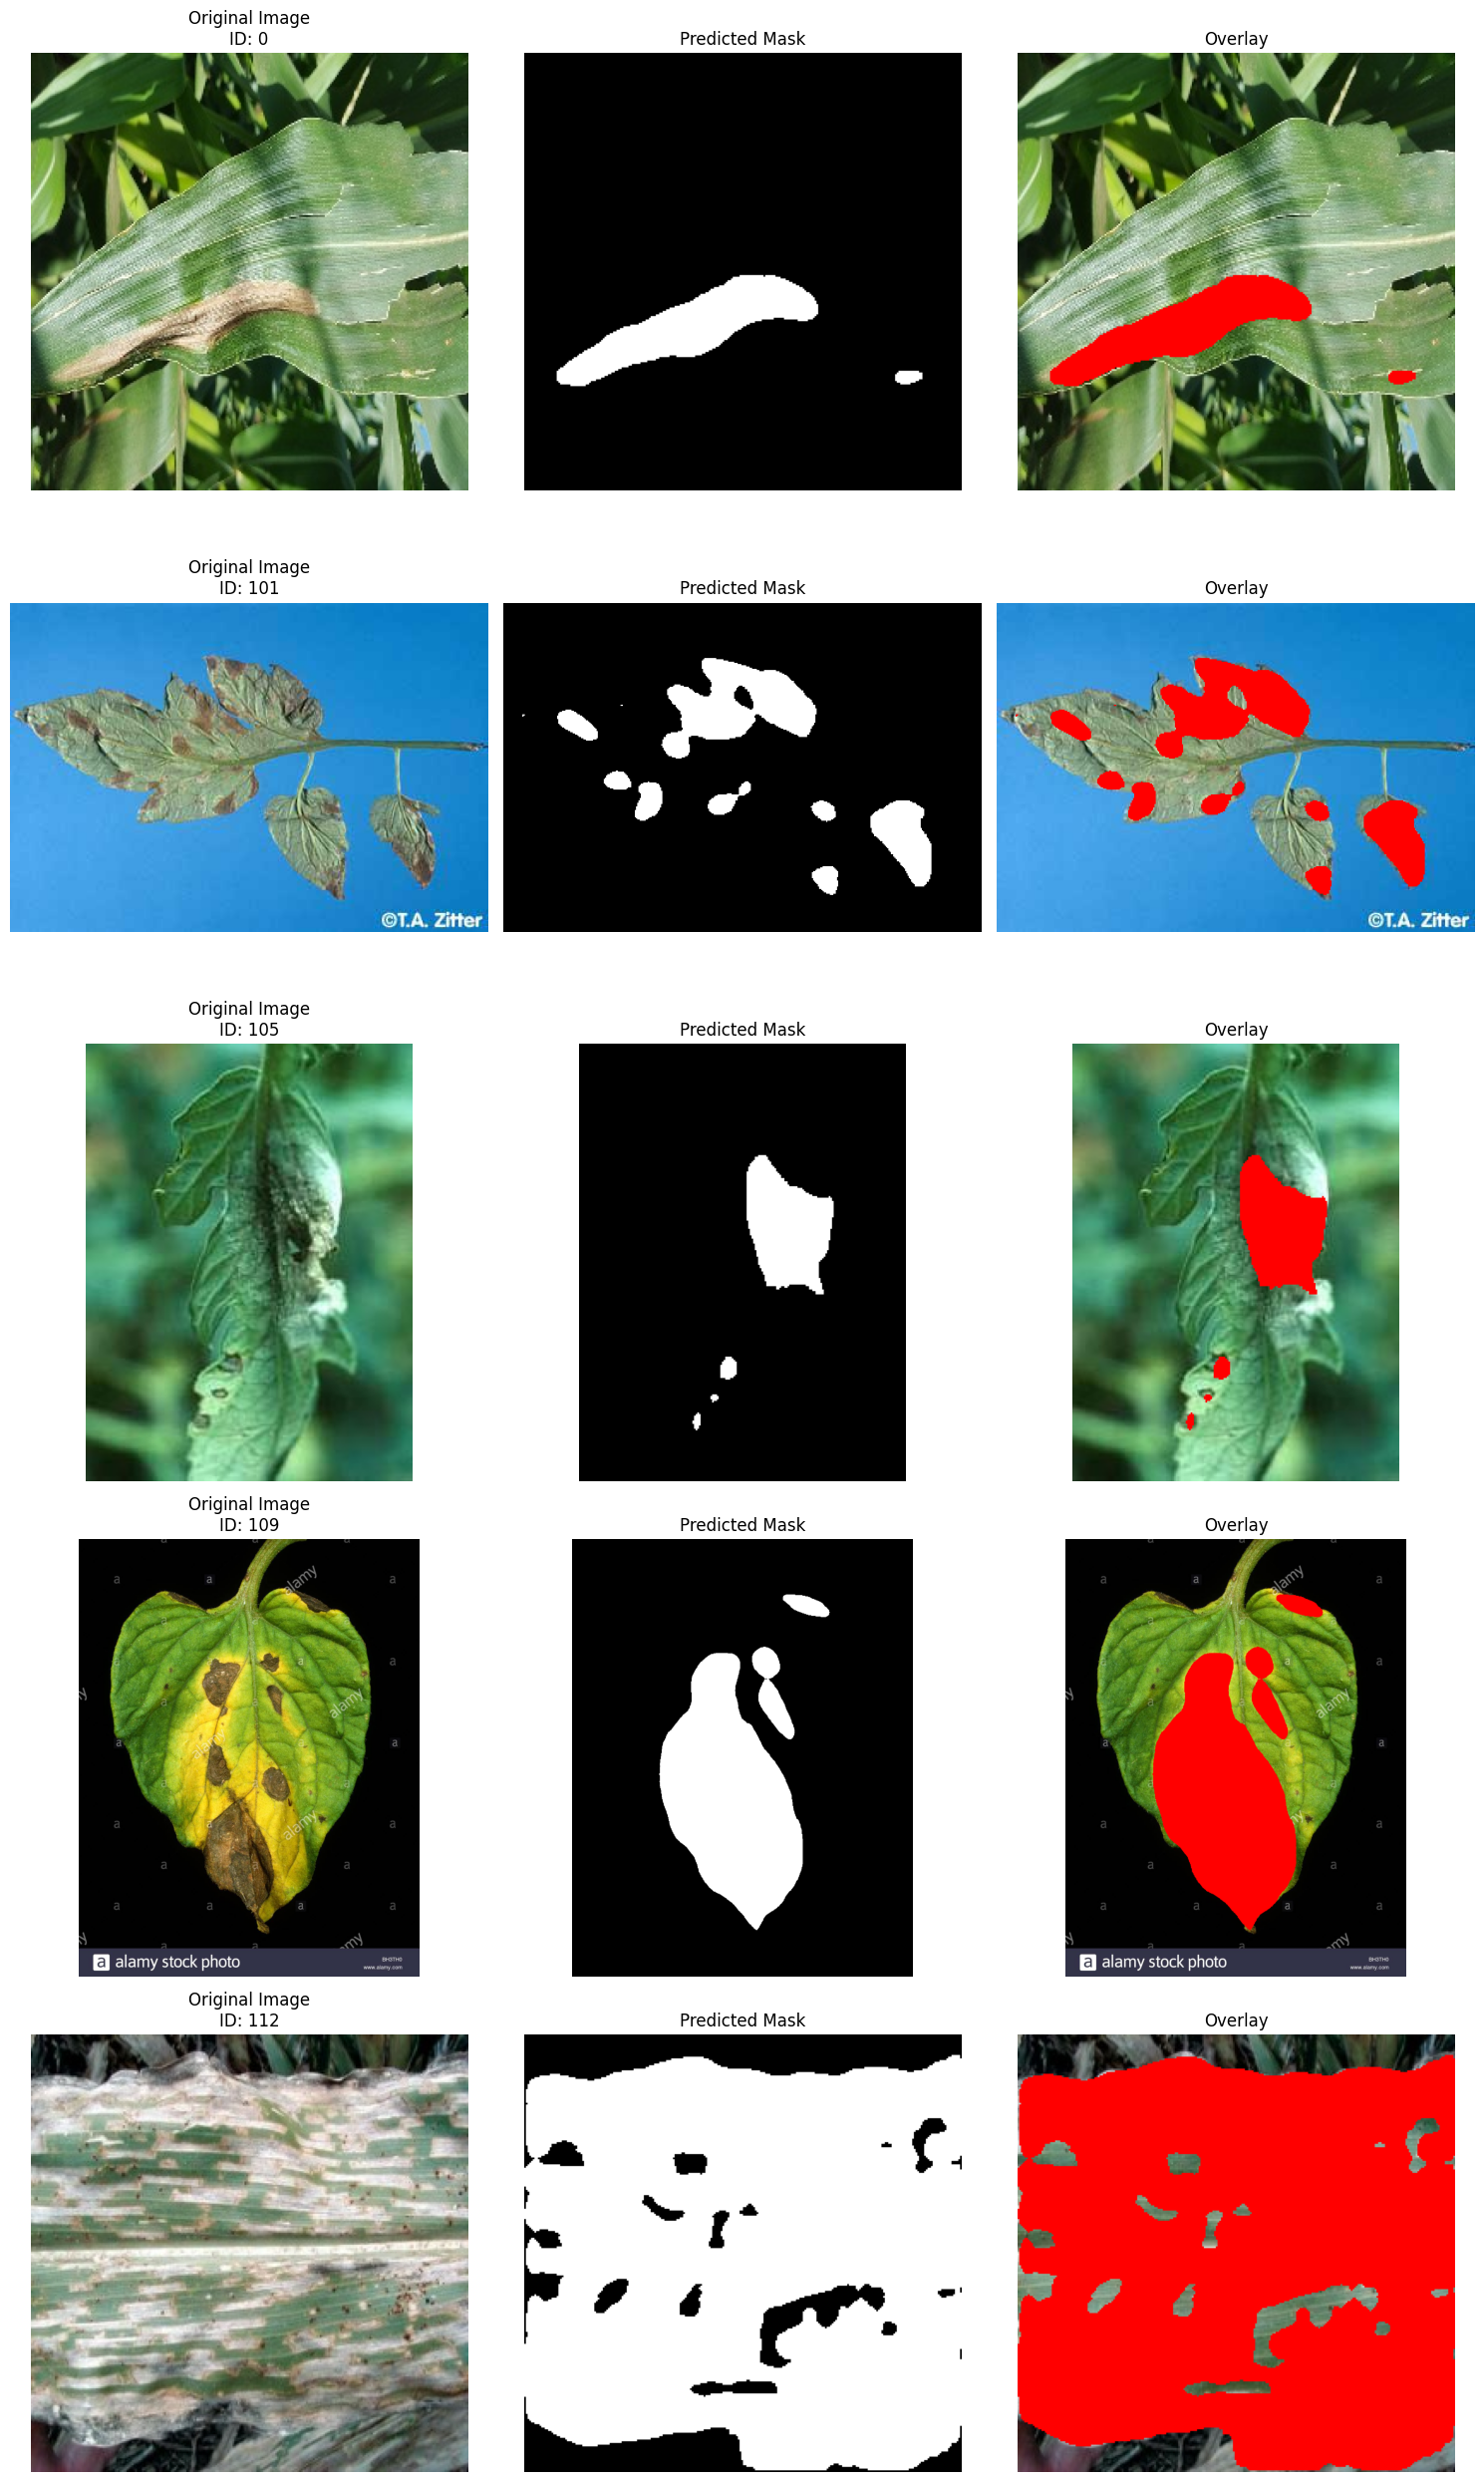

In [47]:
import matplotlib.pyplot as plt
import cv2

def plot_examples(model, test_loader, device, num_examples=5, threshold=0.5):
    """Plot example predictions with their RLE strings.
    
    Args:
        model (nn.Module): Trained model
        test_loader (DataLoader): Test dataset loader
        device (torch.device): Device to run inference on
        num_examples (int): Number of examples to plot
        threshold (float): Threshold for binarizing predictions
    """
    model.eval()
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5*num_examples))
    
    with torch.no_grad():
        for i, (images, image_ids) in enumerate(test_loader):
            if i >= num_examples:
                break
                
            images = images.to(device)
            preds = torch.sigmoid(model(images))
            pred_mask = (preds[0, 0].cpu().numpy() > threshold).astype(np.uint8)
            
            original_img = np.array(Image.open(os.path.join("/kaggle/input/leafdisease/test/images", image_ids[0] + ".jpg")))
            
            if pred_mask.shape != original_img.shape[:2]:
                pred_mask = cv2.resize(pred_mask, (original_img.shape[1], original_img.shape[0]), 
                                       interpolation=cv2.INTER_NEAREST)
            
            overlay = original_img.copy()
            overlay[pred_mask == 1] = [255, 0, 0]
            
            axes[i, 0].imshow(original_img)
            axes[i, 0].set_title(f"Original Image\nID: {image_ids[0]}")
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(pred_mask, cmap='gray')
            axes[i, 1].set_title("Predicted Mask")
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(overlay)
            axes[i, 2].set_title("Overlay")
            axes[i, 2].axis('off')
            
            rle = rle_encode(pred_mask)
            print(f"Example {i+1} - Image ID: {image_ids[0]}")
            print(f"RLE mask string (first 50 chars): {rle[:50]}...")
            print("-"*50)
    
    plt.tight_layout()
    plt.show()

plot_examples(model, test_loader, DEVICE, num_examples=5)